In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tickers = ["AAPL", "AMZN", "META", "TSLA", "GOOGL"]

# use adjusted series automatically
data = yf.download(tickers, period="3y", auto_adjust=True)

# close is already adjusted when auto_adjust=True
prices = data["Close"]

rets = prices.pct_change().dropna() #simpe daily returns

rets.tail(), rets.columns

[*********************100%***********************]  5 of 5 completed


(Ticker          AAPL      AMZN     GOOGL      META      TSLA
 Date                                                        
 2025-10-20  0.039439  0.016147  0.012831  0.021272  0.018484
 2025-10-21  0.002021  0.025637 -0.023738  0.001502 -0.010795
 2025-10-22 -0.016440 -0.018376  0.004911  0.000191 -0.008202
 2025-10-23  0.004372  0.014407  0.005523  0.000804  0.022803
 2025-10-24  0.012482  0.014112  0.027027  0.005940 -0.033988,
 Index(['AAPL', 'AMZN', 'GOOGL', 'META', 'TSLA'], dtype='object', name='Ticker'))

In [5]:
# Covariance and correlation matrices
cov_daily = rets.cov()
corr = rets.corr()

# Annualize covariance (aprox 252 trading days)
cov_annual = cov_daily * 252

cov_daily, corr, cov_annual

(Ticker      AAPL      AMZN     GOOGL      META      TSLA
 Ticker                                                  
 AAPL    0.000301  0.000181  0.000176  0.000203  0.000307
 AMZN    0.000181  0.000441  0.000247  0.000340  0.000332
 GOOGL   0.000176  0.000247  0.000390  0.000271  0.000286
 META    0.000203  0.000340  0.000271  0.000699  0.000315
 TSLA    0.000307  0.000332  0.000286  0.000315  0.001523,
 Ticker      AAPL      AMZN     GOOGL      META      TSLA
 Ticker                                                  
 AAPL    1.000000  0.496237  0.512722  0.443240  0.452657
 AMZN    0.496237  1.000000  0.596587  0.611656  0.405707
 GOOGL   0.512722  0.596587  1.000000  0.518709  0.370599
 META    0.443240  0.611656  0.518709  1.000000  0.304847
 TSLA    0.452657  0.405707  0.370599  0.304847  1.000000,
 Ticker      AAPL      AMZN     GOOGL      META      TSLA
 Ticker                                                  
 AAPL    0.075855  0.045544  0.044291  0.051241  0.077242
 AMZN    0.0

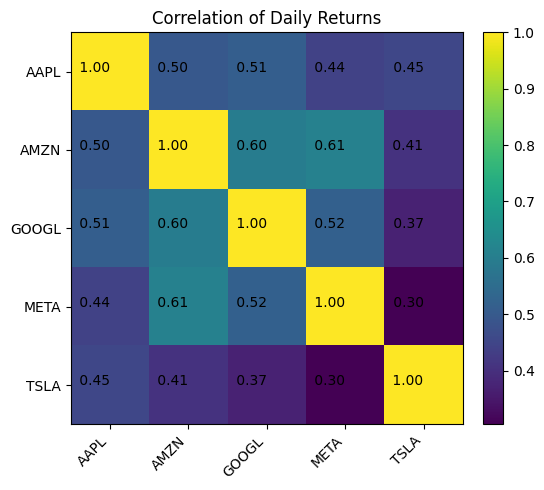

In [9]:
# Visualize with a heatmap 
def heatmap(df, title):
    plt.figure(figsize=(6,5))
    im = plt.imshow(df.values, interpolation = "nearest")
    plt.title(title)
    plt.xticks(range(df.shape[1]), df.columns, rotation=45, ha="right")
    plt.yticks(range(df.shape[0]), df.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # annotate numbers
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            plt.text(j, i, f"{df.values[i,j]: .2f}", ha="right")
    plt.tight_layout()
    plt.show()

heatmap(corr, "Correlation of Daily Returns")

Interpretation:

Close to +1: move together strongly (similar news/sector).

Around 0: largely independent. 

Negative: tend to move opposite (rare among big tech).

In [16]:
# Portfolio variance and standard deviation

def portfolio_stats(weights, cov_annual):
    """weights: pd.Series aligned to cov_annual columns, sums to 1"""
    w = weights.values.reshape(-1, 1)
    var = (w.T @ cov_annual.values @ w).item()
    std = np.sqrt(var)
    return var, std

# Equal-weight portfolio
w_eq = pd.Series(1/len(tickers), index=tickers)
var_eq, std_eq = portfolio_stats(w_eq, cov_annual)

print("Portfolio variance:", var_eq)
print("Portfolio standard deviation:", std_eq)

Portfolio variance: 0.08738015309948653
Portfolio standard deviation: 0.2956013415048831


In [32]:
# Compute monthly variance and daily variance

ann_vol = std_eq                  # ~0.2956 (29.56%)
monthly_vol = (ann_vol / np.sqrt(12)) * 100
daily_vol   = (ann_vol / np.sqrt(252)) * 100

print(f"Portfolio monthly volatility: {monthly_vol: .2f}%")
print(f"Portfolio daily volatility: {daily_vol: .2f}%")

Portfolio monthly volatility:  8.53%
Portfolio daily volatility:  1.86%


In [34]:
# Custom weights + risk contributions

#Example 2: custom weights (sum must be 1)
#w = pd.Series({"AAPL":0.20,"AMZN":0.20,"META":0.20,"TSLA":0.20,"GOOGL":0.20})
w = pd.Series({"AAPL":0.15,"AMZN":0.25,"META":0.20,"TSLA":0.10,"GOOGL":0.30})

# Normalize just in case
w = w / w.sum()

var_p, std_p = portfolio_stats(w, cov_annual)
print("Annualized portfolio stdev:", round(std_p,4))

# Marginal & contribution to risk
Sigma = cov_annual.values
w_vec = w.values.reshape(-1,1)
marginal = (Sigma @ w_vec).flatten()           # ∂σ²/∂w ≈ 2Σw; up to scaling
contr = w.values * marginal                    # component (not normalized)
# normalize contributions to sum to portfolio variance
contr_norm = contr / contr.sum() * var_p

pd.DataFrame({
    "weight": w,
    "risk_contribution(variance)": contr_norm
}).T

Annualized portfolio stdev: 0.3204


,AAPL,AMZN,META,TSLA,GOOGL
weight,0.150000,0.250000,0.200000,0.100000,0.300000
risk_contribution(variance),0.008988,0.020187,0.014069,0.008414,0.051006
